In [81]:
from pathlib import Path
import pickle
import jax
import matplotlib.pyplot as plt

from src.models.CCVAE import CCVAE
from src.models.encoder_decoder import get_encoder_decoder
from src.data_loading.loaders import get_data_loaders
from src.models.config import get_config
from numpyro.infer import Predictive

import jax.random as jrandom
import jax.numpy as jnp
key = jrandom.PRNGKey(0)

In [82]:
# Set up random seed
seed = 42
p_supervised = 0.2

# DATASET
dataset_name = "MNIST" #"MNIST" # use "CIFAR10"

config = get_config(dataset_name)
encoder_class, decoder_class = get_encoder_decoder(dataset_name)

distribution = config["distribution"]

cmap = "gray" if dataset_name == "MNIST" else None
# Data loading

img_shape, loader_dict, size_dict = get_data_loaders(dataset_name=dataset_name, 
                                          p_test=0.1, 
                                          p_val=0.1, 
                                          p_supervised=p_supervised, 
                                          batch_size=64, 
                                          num_workers=6, 
                                          seed=seed)


scale_factor = config['scale_factor'] * size_dict["supervised"] # IMPORTANT, maybe run a grid search (0.3 on cifar)

# Set up model
ccvae = CCVAE(encoder_class, 
               decoder_class, 
               config['num_classes'],
               config['latent_dim'], 
               img_shape, 
               distribution=distribution,
               multiclass=config['multiclass'],
)
print("Model set up!")

Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 6000
Num validation samples: 5400
Num supervised samples: 38880
Num unsupervised samples: 9720
Beta factor:  1.0
Model set up!


In [83]:
folder_path = Path("./model_weights")
save_path = "ccvae_" + dataset_name + "_p_supervised_" + str(p_supervised) + "_seed_" + str(seed) + ".pkl"
with open(folder_path/save_path, 'rb') as file:
    params=pickle.load(file)

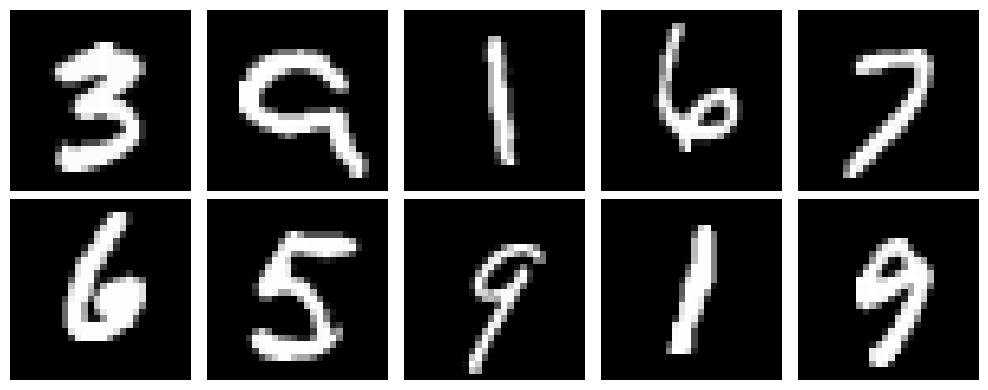

In [84]:
#xs = jnp.zeros((10,) + img_shape)
#ys = jnp.array([i for i in range(10)])

# OR 
load = iter(loader_dict["test"])
xs, ys = next(load)

n_rows = 2
n_cols = 5

plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows):
    for j in range(n_cols):
        plt.subplot(n_rows, n_cols, i * n_cols + j + 1)
        image = xs[i * n_cols + j]
        
        if dataset_name == "MNIST":
            image = image.squeeze(-1)
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
        plt.axis('off')  # Turn off the axis labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [85]:
print(xs.shape, ys.shape)

(64, 28, 28, 1) (64,)


In [86]:
predictive = Predictive(ccvae.model_supervised, guide=ccvae.guide_supervised, params=params, num_samples=25, return_sites=["loc", "z_class", "z_style"])

rng_key = jax.random.PRNGKey(0) 
predictions = predictive(rng_key, xs, ys)

loc = predictions['loc']
z_class = predictions['z_class']
z_style = predictions['z_style']

print(loc.shape, z_class.shape, z_style.shape)

(25, 64, 28, 28, 1) (25, 64, 10) (25, 64, 40)


In [87]:
class_number = 1

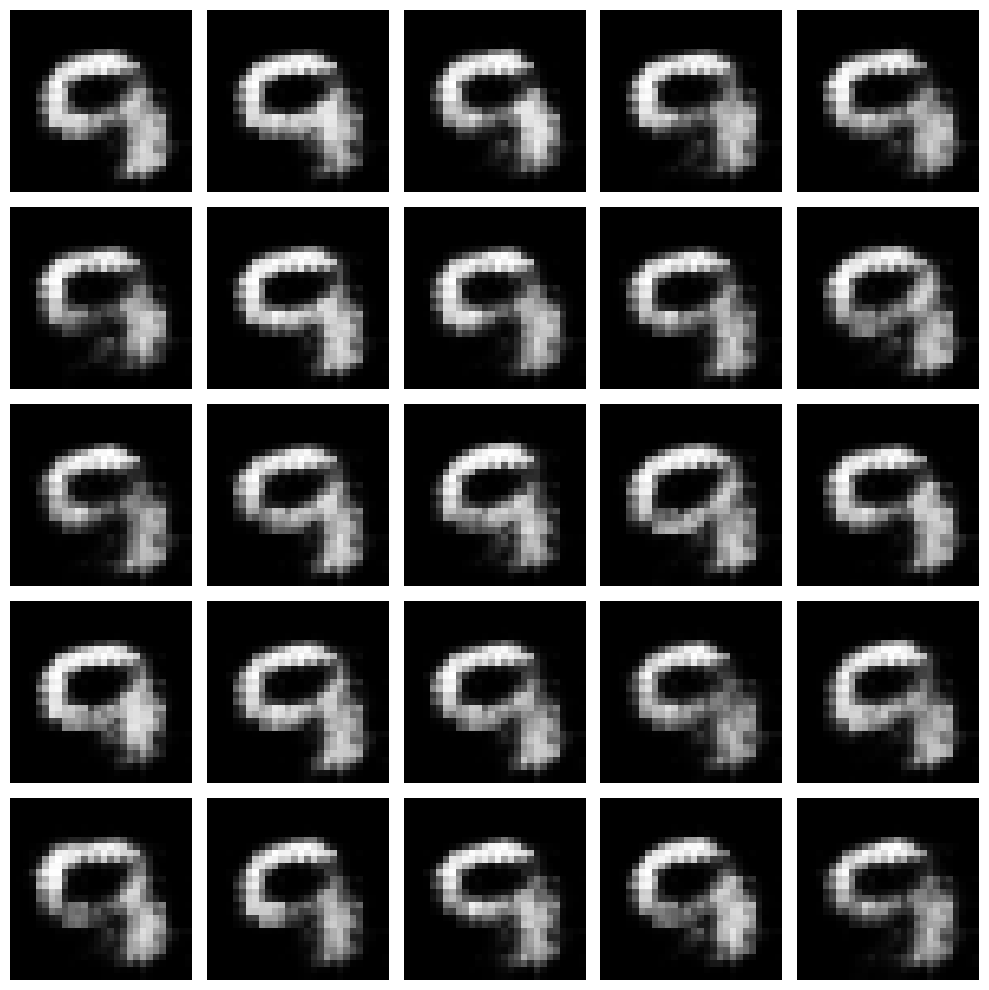

In [88]:
n_rows = 5
n_cols = 5

plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    image = loc[i, class_number]

    if dataset_name == "MNIST":
        image = image.squeeze(-1)
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.axis('off')  # Turn off the axis labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [89]:
class_number = 6

In [90]:
## Fix the classes and vary the style
## Sample 3 random points from the latent space

z = jax.random.normal(rng_key, (3, 40))

## Construct a fourth point that is in the plane of the three points

z1 = z[0]
z2 = z[1]
z3 = z[2]
z4 = z2 + z3 - z1

## Construct a grid of barycentric weights for the 4 points

n_rows = 6
n_cols = 6

barycentric_weights = jnp.zeros((n_rows, n_cols, 4))
for i in range(n_rows):
    for j in range(n_cols):
        barycentric_weights = barycentric_weights.at[i, j, 0].set(i / (2* n_rows - 2))
        barycentric_weights = barycentric_weights.at[i, j, 1].set(j / (2* n_cols - 2))
        barycentric_weights = barycentric_weights.at[i, j, 2].set((n_cols - i) / (2* n_cols - 2))
        barycentric_weights = barycentric_weights.at[i, j, 3].set((n_rows - j) / (2* n_rows - 2))

## Construct the latent space grid
        
z_grid = jnp.zeros((n_rows, n_cols, 40))
for i in range(n_rows):
    for j in range(n_cols):
        z_grid = z_grid.at[i, j].set(barycentric_weights[i, j, 0] * z1 + barycentric_weights[i, j, 1] * z2 + barycentric_weights[i, j, 2] * z3 + barycentric_weights[i, j, 3] * z4)

In [91]:
z_grid = z_grid.reshape(-1, 40)

In [92]:
z_grid.shape

(36, 40)

In [93]:
latent_class = z_class[0,class_number]
latent_grid = jnp.concatenate([latent_class.reshape(-1, 10).repeat(n_rows * n_cols, axis=0), z_grid], axis=1)

In [94]:
params.keys()

dict_keys(['classifier$params', 'cond_prior_class$params', 'decoder$params', 'encoder$params'])

In [95]:
loc_grid = ccvae.internal_decoder.apply({'params' : params['decoder$params']}, latent_grid)

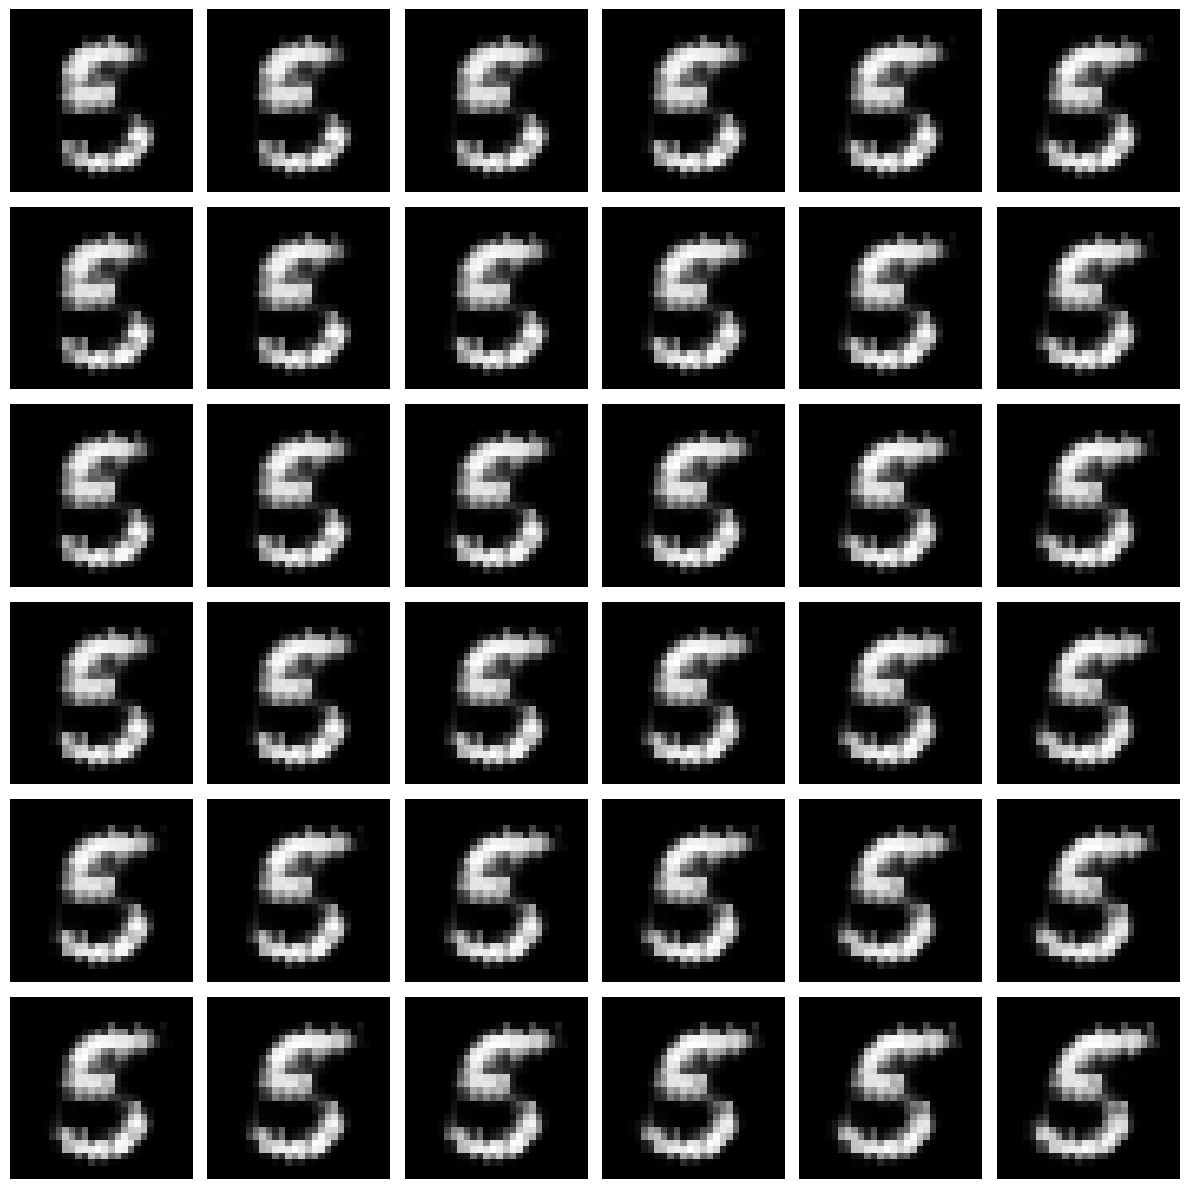

In [96]:
## Plot the grid

n_rows = 6
n_cols = 6

plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    image = loc_grid[i]

    if dataset_name == "MNIST":
        image = image.squeeze(-1)
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.axis('off')  # Turn off the axis labels

# Adjust layout and show the plot
plt.tight_layout()

In [97]:
## Style transfer, fix the style and vary the class

style = z_style[0, class_number]
all_classes = jnp.eye(10)
z_class_prior_loc, z_class_prior_scale = ccvae.internal_cond_prior_class.apply({'params' : params['cond_prior_class$params']}, all_classes)
z_class_prior_scale = jnp.exp(z_class_prior_scale)
z_class = jax.random.normal(rng_key, (10, 10)) * z_class_prior_scale + z_class_prior_loc
latent_grid = jnp.concatenate([z_class, style.reshape(-1, 40).repeat(10, axis=0)], axis=1)

loc_grid = ccvae.internal_decoder.apply({'params' : params['decoder$params']}, latent_grid)

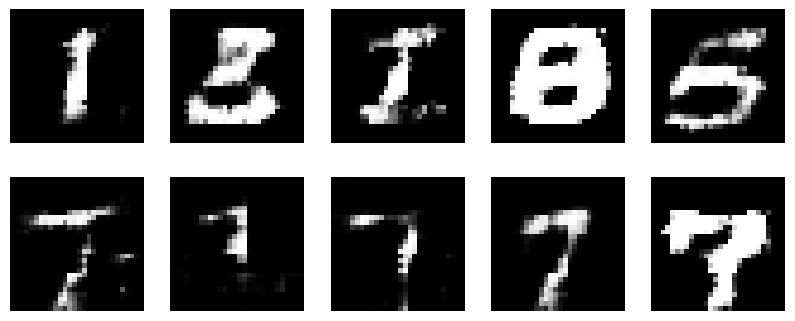

In [98]:
## Plot the grid

n_rows = 2
n_cols = 5

plt.figure(figsize=(n_cols * 2, n_rows * 2))

for i in range(n_rows):
    for j in range(n_cols):
        plt.subplot(n_rows, n_cols, i * n_cols + j + 1)
        image = loc_grid[i * n_cols + j]

        if dataset_name == "MNIST":
            image = image.squeeze(-1)
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
        plt.axis('off')  # Turn off the axis labels